# EQS GB Cross-Validation for Simple sources

In [6]:
import warnings
import itertools
import numpy as np
import verde as vd
import harmonica as hm
import pandas as pd
import xarray as xr
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import eqs_magnetics as eqs
import synthetics

In [7]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Create a simple synthetic

Set the data coordinates and field direction.

N data: 92046


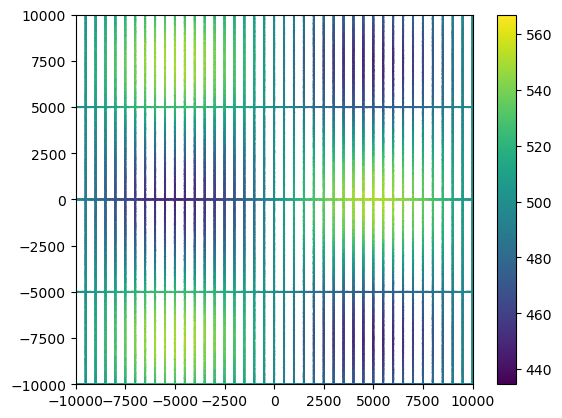

In [14]:
region = [-10e3, 10e3, -10e3, 10e3]
# Inc and dec from the IGRF around Antarctica
field_direction = np.array([hm.magnetic_angles_to_vec(1, 84, 40)]).T

# Generate fake flight lines
easting, northing = [c.ravel() for c in vd.grid_coordinates(region, spacing=(10, 500))]
easting_tie, northing_tie = [c.ravel() for c in vd.grid_coordinates(region, spacing=(5000, 10))]
easting = np.concatenate([easting, easting_tie])
northing = np.concatenate([northing, northing_tie])
upward = vd.synthetic.CheckerBoard(region=region, amplitude=50, w_east=20000, w_north=15000).predict((easting, northing)) + 500
coordinates = (easting, northing, upward)
for i, c in enumerate(coordinates):
    eqs.contaminate(c, standard_deviation=5, random_state=i)

print("N data:", coordinates[0].size)

plt.scatter(*coordinates[:2], c=coordinates[2], s=0.1)
plt.xlim(*region[:2])
plt.ylim(*region[2:])
plt.colorbar()
plt.show()

Create the dipole source model.

In [15]:
source_direction = [70, 60] # [inc, dec]
source_coordinates, dipole_moments = synthetics.simple_synthetic(
    dike1=source_direction,
    dike2=source_direction,
    point1=source_direction,
    point2=source_direction,
    point3=source_direction,
    point4=source_direction,
    regional=source_direction,
)

b_field = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)
tfa = eqs.contaminate(
    eqs.total_field_anomaly(b_field, field_direction), standard_deviation=50, random_state=42,
)
bnorm = eqs.magnetic_field_norm(b_field)

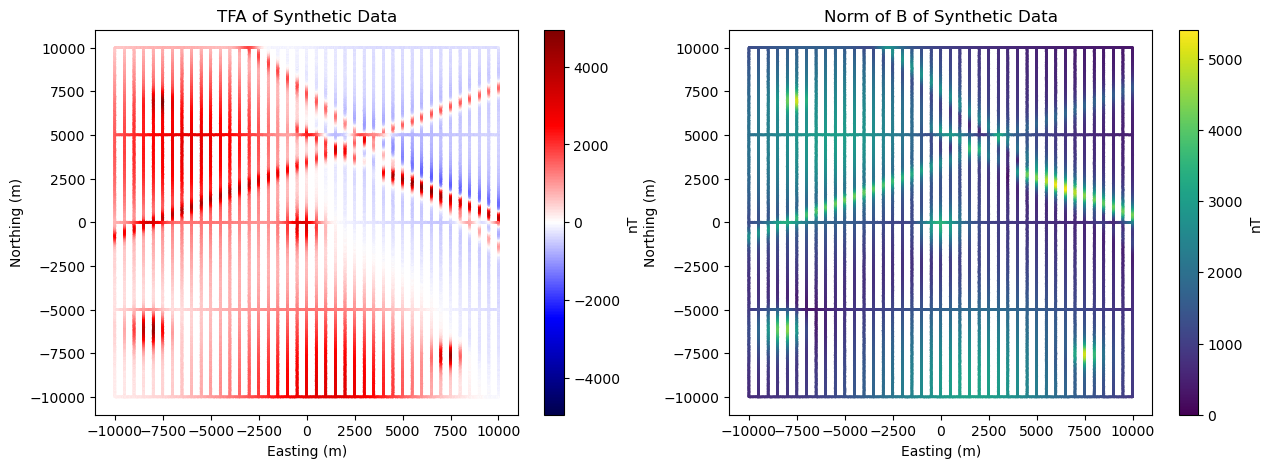

In [16]:
plt.figure(figsize=(15,5))
scale = vd.maxabs(tfa)
#scale = 1000
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa, cmap="seismic", s=0.5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

scale_bnorm = vd.maxabs(bnorm)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=bnorm, cmap="viridis", s=0.5, vmin=0, vmax=scale_bnorm)
plt.title("Norm of B of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Single layer

In [17]:
dampings_single_layer = [1e3, 1e4, 1e5]
depths_single_layer = [3.3e3 3.4e3, 3.5e3]
parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_single_layer, depths_single_layer)
]
print("Number of combinations:", len(parameter_sets))

Number of combinations: 15


In [18]:
%%time
kfold = vd.BlockKFold(
    spacing=2.5e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores_single_layer = []
damping_single_layer = []
source_depth_single_layer = []
for parameters in parameter_sets:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=100, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa[test] - predicted))
    scores_single_layer.append(np.mean(tmp))
    damping_single_layer.append(parameters['damping'])
    source_depth_single_layer.append(parameters['depth'])

{'damping': 10.0, 'depth': 3500.0}
{'damping': 10.0, 'depth': 3600.0}
{'damping': 10.0, 'depth': 3700.0}
{'damping': 10.0, 'depth': 3800.0}
{'damping': 10.0, 'depth': 3900.0}
{'damping': 100.0, 'depth': 3500.0}
{'damping': 100.0, 'depth': 3600.0}
{'damping': 100.0, 'depth': 3700.0}
{'damping': 100.0, 'depth': 3800.0}
{'damping': 100.0, 'depth': 3900.0}
{'damping': 1000.0, 'depth': 3500.0}
{'damping': 1000.0, 'depth': 3600.0}
{'damping': 1000.0, 'depth': 3700.0}
{'damping': 1000.0, 'depth': 3800.0}
{'damping': 1000.0, 'depth': 3900.0}
CPU times: user 2h 54min 6s, sys: 1min 27s, total: 2h 55min 34s
Wall time: 27min


{'damping': 1000.0, 'depth': 3500.0}

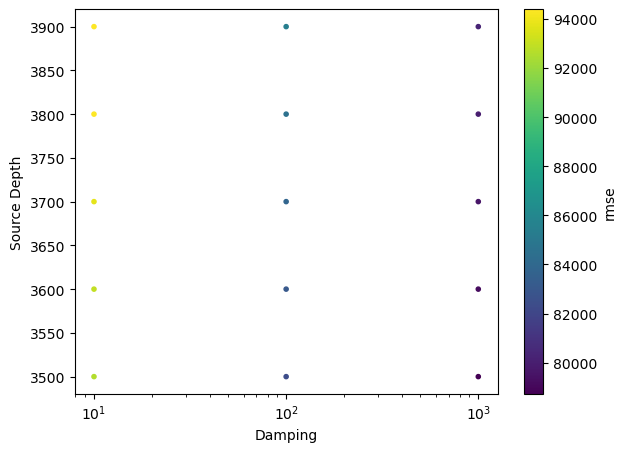

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(
    damping_single_layer,
    source_depth_single_layer,
    c=scores_single_layer,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores_single_layer,90),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')

best_single_layer = np.argmin(scores_single_layer)
parameter_sets[best_single_layer]

In [22]:
eqs_single = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=100, **parameter_sets[best_single_layer])
eqs_single.fit(coordinates, tfa, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

dipole height: -3379.137527050155
window size: 5240.607602578799


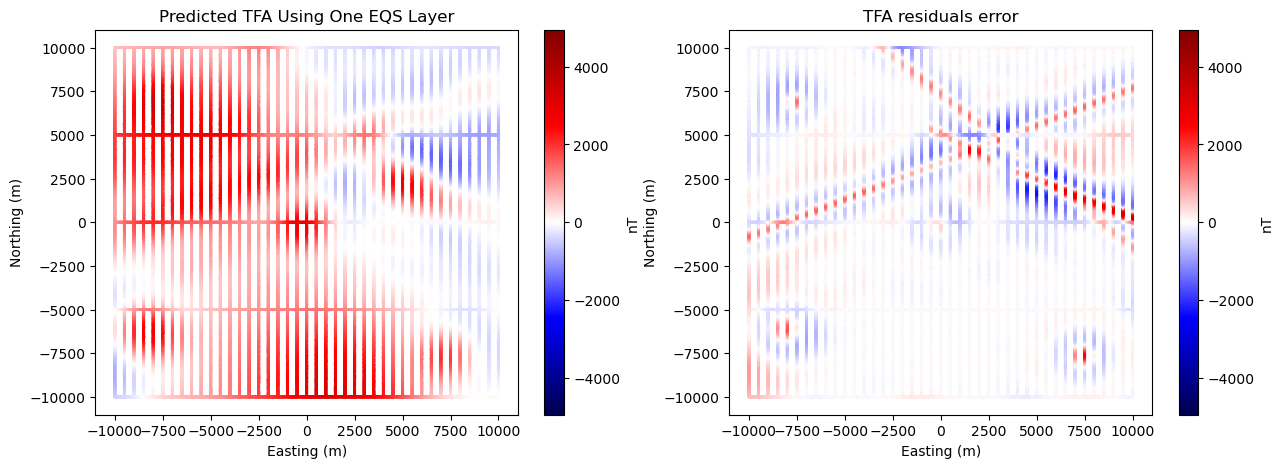

In [23]:
tfa_prediction_single_layer = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_prediction_single_layer, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using One EQS Layer")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa - tfa_prediction_single_layer, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("TFA residuals error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit deep sources

Block reduce the data has several advantages:

1. Less data to fit so much faster.
2. The block median reduces the wavelengths in the data, which captures the regional field and leaves the residuals alone.

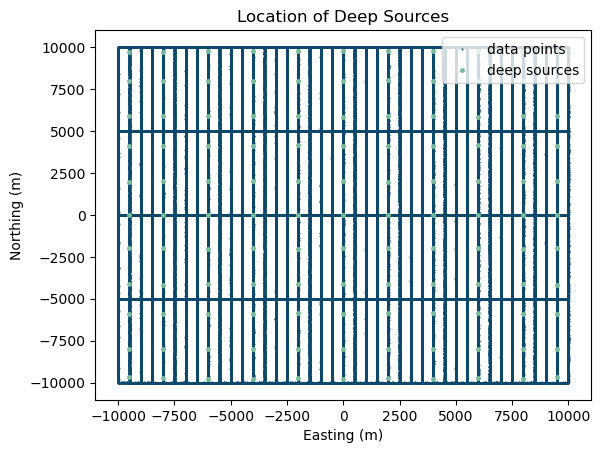

In [13]:
block_spacing = 2e3
reducer = vd.BlockReduce(
    reduction=np.median,
    spacing=block_spacing,
    region=(vd.pad_region(region, pad=block_spacing*0.5)),
    drop_coords=False
)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=tfa)

plt.figure()
plt.plot(*coordinates[:2], ".", color="#0B486B", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], ".", color="#79BD9A", markersize=5, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.show()

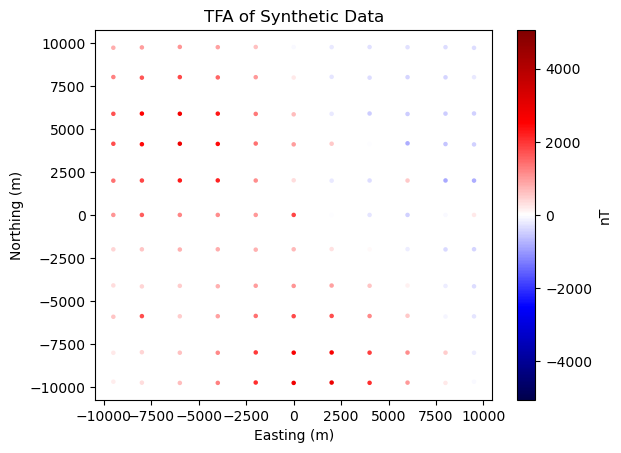

In [14]:
plt.figure()
plt.scatter(*coords_blocked[:2], c=tfa_blocked, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

In [15]:
dampings_deep_eqs = [1e-5, 1e-4, 1e-3, 1e-2, 1, 1e-1, 1e1, 1e2, 1e3, 1e4, 1e5]
spacing = np.mean(vd.median_distance(coords_blocked))
depths_deep_eqs = [spacing*2.5, spacing*3, spacing*3.5, spacing*4, spacing*4.25, spacing*4.5, spacing*5, spacing*5.5, spacing*6]
parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_deep_eqs, depths_deep_eqs)
]
print("Number of combinations:", len(parameter_sets))
# print("Combinations:", parameter_sets)

Number of combinations: 99


In [16]:
%%time
kfold = vd.BlockKFold(
    spacing=2500,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores = []
damping = []
source_depth = []
for parameters in parameter_sets:    
    print(parameters)
    eqs_deep = eqs.EquivalentSourcesMagnetic(block_size=100, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_blocked[test] - predicted))
    scores.append(np.mean(tmp))
    damping.append(parameters['damping'])
    source_depth.append(parameters['depth'])

{'damping': 1e-05, 'depth': 4259.614334078467}
{'damping': 1e-05, 'depth': 5111.53720089416}
{'damping': 1e-05, 'depth': 5963.460067709853}
{'damping': 1e-05, 'depth': 6815.382934525547}
{'damping': 1e-05, 'depth': 7241.344367933394}
{'damping': 1e-05, 'depth': 7667.305801341241}
{'damping': 1e-05, 'depth': 8519.228668156935}
{'damping': 1e-05, 'depth': 9371.151534972627}
{'damping': 1e-05, 'depth': 10223.07440178832}
{'damping': 0.0001, 'depth': 4259.614334078467}
{'damping': 0.0001, 'depth': 5111.53720089416}
{'damping': 0.0001, 'depth': 5963.460067709853}
{'damping': 0.0001, 'depth': 6815.382934525547}
{'damping': 0.0001, 'depth': 7241.344367933394}
{'damping': 0.0001, 'depth': 7667.305801341241}
{'damping': 0.0001, 'depth': 8519.228668156935}
{'damping': 0.0001, 'depth': 9371.151534972627}
{'damping': 0.0001, 'depth': 10223.07440178832}
{'damping': 0.001, 'depth': 4259.614334078467}
{'damping': 0.001, 'depth': 5111.53720089416}
{'damping': 0.001, 'depth': 5963.460067709853}
{'dampi

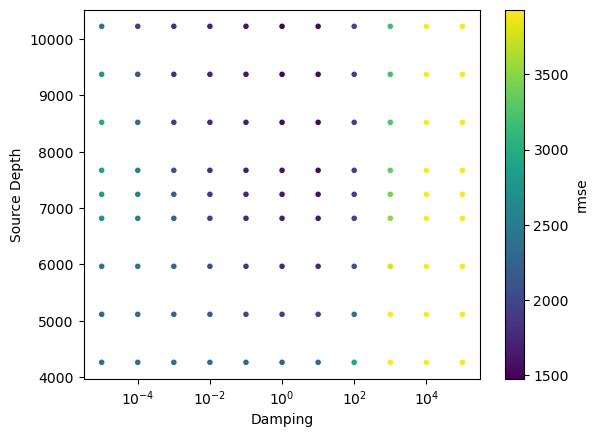

{'damping': 1, 'depth': 10223.07440178832}

In [17]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=scores,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores,80),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

best = np.argmin(scores)
parameter_sets[best]

In [18]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(**parameter_sets[best])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -9718.503928355649
CPU times: user 161 ms, sys: 0 ns, total: 161 ms
Wall time: 24.5 ms


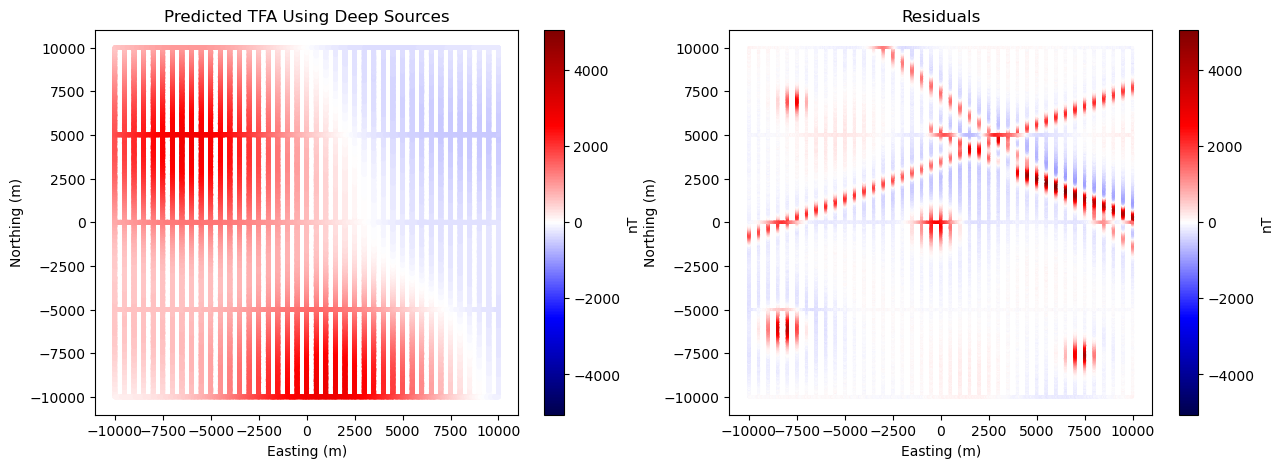

In [19]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = tfa - tfa_deep

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit the deep residuals with gradient-boosted sources

In [20]:
dampings = [1e-4, 1e-3, 1e-2, 1e-1]
depths = [1e3, 1.5e3, 2e3]
parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
# print("Combinations:", parameter_sets)

Number of combinations: 12


In [21]:
%%time
kfold = vd.BlockKFold(
    spacing=3e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
damping = []
source_depth = []
for parameters in parameter_sets:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=100, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    scores.append(np.mean(tmp))
    damping.append(parameters['damping'])
    source_depth.append(parameters['depth'])

{'damping': 0.0001, 'depth': 1000.0}
{'damping': 0.0001, 'depth': 1500.0}
{'damping': 0.0001, 'depth': 2000.0}


KeyboardInterrupt: 

{'damping': 0.001, 'depth': 1000.0}

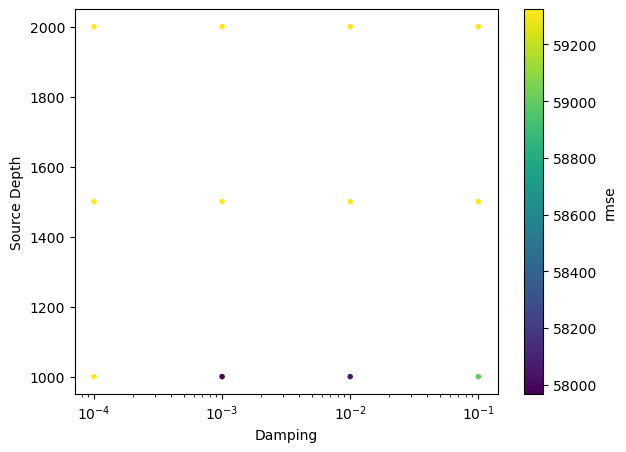

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(
    damping,
    source_depth,
    c=scores,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores,20),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')

best = np.argmin(scores)
parameter_sets[best]

In [ ]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=100, **parameter_sets[best])
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

dipole height: -500.39637958750143
window size: 4669.642453391388
CPU times: user 3min 20s, sys: 595 ms, total: 3min 21s
Wall time: 31.5 s


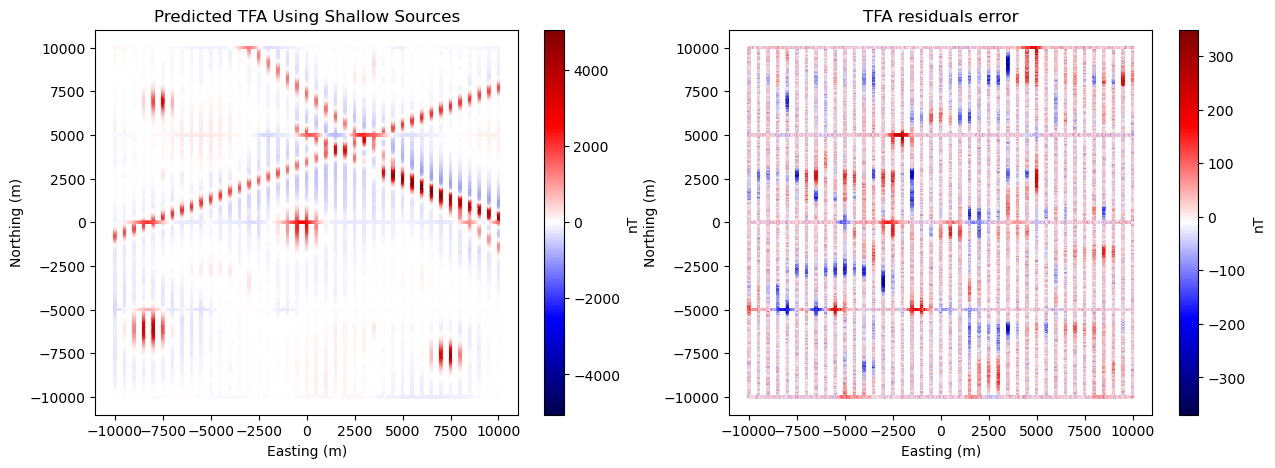

In [ ]:
tfa_residuals_prediction = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa_residuals - tfa_residuals_prediction, cmap="seismic", s=1)
plt.title("TFA residuals error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Predict the norm of B

In [ ]:
grid_coordinates = vd.grid_coordinates(region, spacing=100, extra_coords=500)
true_b = eqs.dipole_magnetic(grid_coordinates, source_coordinates, dipole_moments)
predicted_b = eqs_deep.predict(grid_coordinates) + eqs_shallow.predict(grid_coordinates)

true_tfa = eqs.total_field_anomaly(true_b, field_direction)
predicted_tfa = eqs.total_field_anomaly(predicted_b, field_direction)
error_tfa = true_tfa - predicted_tfa

In [ ]:
true_norm_of_b = np.sqrt(sum(c**2 for c in true_b))
predicted_norm_of_b = np.sqrt(sum(c**2 for c in predicted_b))
error_norm_of_b = true_norm_of_b - predicted_norm_of_b

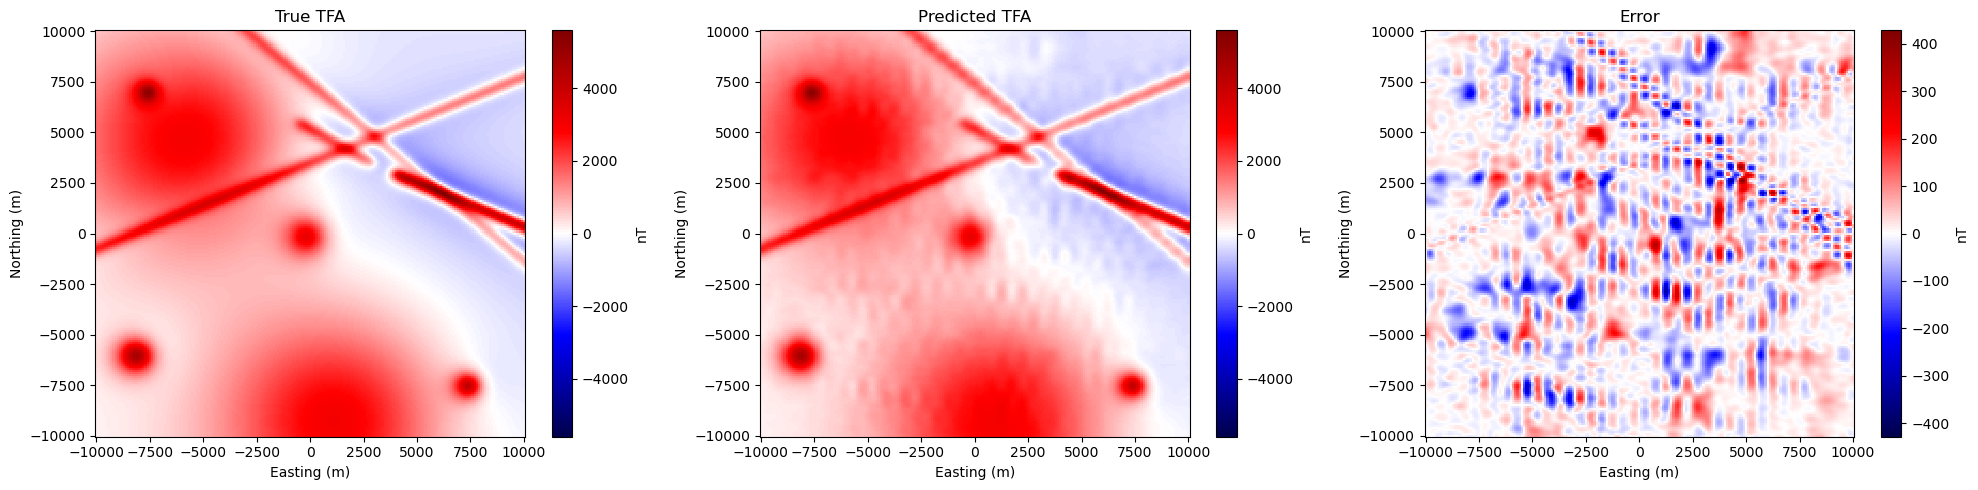

In [ ]:
scale_tfa = vd.maxabs(true_tfa)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="seismic", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_tfa, cmap="seismic", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = vd.maxabs(error_tfa)
plt.pcolormesh(*grid_coordinates[:2], error_tfa, cmap="seismic", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

In [ ]:
scale_b = vd.maxabs(true_norm_of_b)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_norm_of_b, cmap="viridis", vmin=0, vmax=scale_b)
plt.title("True Norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_norm_of_b, cmap="viridis", vmin=0, vmax=scale_b)
plt.title("Predicted Norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = vd.maxabs(error_norm_of_b)
plt.pcolormesh(*grid_coordinates[:2], error_norm_of_b, cmap="seismic", vmin=-scale_b, vmax=scale_b)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

NameError: name 'vd' is not defined

## Save data

Save data to pandas dataframe

In [ ]:
# simple_synthetic_data = pd.DataFrame(np.transpose(b_field), columns= ['b_easting','b_northing','b_upward'])

In [ ]:
# simple_synthetic_data.insert(0, 'easting', np.transpose(coordinates[0]))
# simple_synthetic_data.insert(1, 'northing', np.transpose(coordinates[1]))
# simple_synthetic_data.insert(2, 'upward', np.transpose(coordinates[2]))
# simple_synthetic_data.insert(3, 'observed_tfa', np.transpose(tfa))
# simple_synthetic_data.insert(7, 'bnorm', np.transpose(bnorm))
# simple_synthetic_data.insert(8, 'tfa_deep', np.transpose(tfa_deep))
# simple_synthetic_data.insert(9, 'tfa_deep_residuals', np.transpose(tfa_residuals))
# simple_synthetic_data.insert(10, 'tfa_shallow', np.transpose(tfa_residuals_prediction))
# simple_synthetic_data.insert(11, 'tfa_shallow_residuals', np.transpose(tfa_residuals - tfa_residuals_prediction))

In [ ]:
# simple_synthetic_data

In [ ]:
# simple_synthetic_sources = pd.DataFrame(np.transpose(source_coordinates), columns= ['easting','northing','upward'])
# simple_synthetic_sources.insert(3, 'dipole_moments_easting', np.transpose(dipole_moments[0]))
# simple_synthetic_sources.insert(4, 'dipole_moments_northing', np.transpose(dipole_moments[1]))
# simple_synthetic_sources.insert(5, 'dipole_moments_upward', np.transpose(dipole_moments[2]))

In [ ]:
# simple_synthetic_sources

Save grid to xarray

In [ ]:
# simple_synthetic_grid = vd.make_xarray_grid(grid_coordinates, data=(true_norm_of_b, predicted_norm_of_b), data_names=('true_bnorm', 'predicted_bnorm'), dims=('northing', 'easting'), extra_coords_names='upward')
# simple_synthetic_grid

- Save pd df to csv
- Save xarray to netCDF

In [ ]:
# simple_synthetic_data.to_csv('simple_synthetic_data.csv', index=False)
# simple_synthetic_sources.to_csv('simple_synthetic_sources.csv', index=False)
# simple_synthetic_grid.to_netcdf('simple_synthetic_grid.nc')